<a href="https://colab.research.google.com/github/sandeshkumar003/Algorithms-Project/blob/main/DeepLearningFall2024/Code/Lab10_Explained_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Notebook 10.2: Convolution for MNIST-1D**

This notebook investigates a 1D convolutional network for MNIST-1D

<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=1Jkp_zo7-EI9UvR2WMIO0PwckiRFmfi6F)
Figure: 1
</center>

<center>

![Google Drive Image](https://drive.google.com/uc?export=view&id=17bHo3pNYS-ea-g56MIGx35AV96vWcqBq)
Figure: 2
</center>




In [ ]:
# Run this if you're in a Colab to install MNIST 1D repository
!pip install git+https://github.com/greydanus/mnist1d

  Cloning https://github.com/greydanus/mnist1d to /tmp/pip-req-build-9gr0d85g
  Running command git clone --filter=blob:none --quiet https://github.com/greydanus/mnist1d /tmp/pip-req-build-9gr0d85g
  Resolved https://github.com/greydanus/mnist1d to commit 7878d96082abd200c546a07a4101fa90b30fdf7e
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mnist1d: filename=mnist1d-0.0.2.post16-py3-none-any.whl size=14625 sha256=1afc0e345314ccc2c2ed62649d55e61cb15a44c3ba2f62c8187efd2ad6b37f4e
  Stored in directory: /tmp/pip-ephem-wheel-cache-kg2wydf9/wheels/41/95/55/45fcf7d38cfa97e35682da6c5017d4513729131326ce935371
Successfully built mnist1d


In [ ]:
import numpy as np
import os
import torch, torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt
import mnist1d
import random

In [ ]:
args = mnist1d.data.get_dataset_args()
data = mnist1d.data.get_dataset(args, path='./mnist1d_data.pkl', download=False, regenerate=False)

print(data.keys())
print(data['y'][0])
# The training and test input and outputs are in
 #data['x'], data['y'], data['x_test'], and data['y_test']
print("Examples in training set: {}".format(len(data['y'])))
print("Examples in test set: {}".format(len(data['y_test'])))
print("Length of each example: {}".format(data['x'].shape[-1]))

Successfully loaded data from ./mnist1d_data.pkl
dict_keys(['x', 'x_test', 'y', 'y_test', 't', 'templates'])
2
Examples in training set: 4000
Examples in test set: 1000
Length of each example: 40


In [ ]:
data['y'].shape

(4000,)

In [ ]:
# Load in the data
train_data_x = data['x'].transpose()
#convert it to 40*4000
train_data_y = data['y']
val_data_x = data['x_test'].transpose()
val_data_y = data['y_test']
# Print out sizes
print("Train data: %d examples (columns), each of which has %d dimensions (rows)"%((train_data_x.shape[1],train_data_x.shape[0])))
print("Validation data: %d examples (columns), each of which has %d dimensions (rows)"%((val_data_x.shape[1],val_data_x.shape[0])))

Train data: 4000 examples (columns), each of which has 40 dimensions (rows)
Validation data: 1000 examples (columns), each of which has 40 dimensions (rows)


Define the network

# Input data For Sequences (1D Data):
##e.g. nn.Conv1d
Shape: (batch_size, channels, length)


* $batch size$: Number of sequences in one batch.
* $channels$: Number of input channels (e.g., 1 for a single-channel time series).
* $length$: Sequence length (e.g., time steps, word count).

In [ ]:


# Example: 1D Convolutional Layer with 1 input channel, 16 output channels, and kernel size 3
conv1d_layer = nn.Conv1d(in_channels=1, out_channels=5, kernel_size=5, stride=1, padding=0)

# Example input: A batch of size 1, with 1 channel and sequence length 10

input_data = torch.randn(2, 1, 10)

# Pass the input through the convolutional layer
output = conv1d_layer(input_data)

print(output.shape)  # Output shape will be (batch_size, out_channels, output_length)


torch.Size([2, 5, 6])


In [ ]:
# There are 40 input dimensions and 10 output dimensions for this data
# The inputs correspond to the 40 offsets in the MNIST1D template.
D_i = 40
# The outputs correspond to the 10 digits
D_o = 10


# Create a model with the following layers
# 1. Convolutional layer, (input=length 40 and 1 channel, kernel size 3, stride 2, padding="valid", 15 output channels )
# 2. ReLU
# 3. Convolutional layer, (input=length 19 and 15 channels, kernel size 3, stride 2, padding="valid", 15 output channels )
# 4. ReLU
# 5. Convolutional layer, (input=length 9 and 15 channels, kernel size 3, stride 2, padding="valid", 15 output channels)
# 6. ReLU
# 7. Flatten (converts 4x15) to length 60
# 8. Linear layer (input size = 60, output size = 10)
model = nn.Sequential(
    #1.  1st Convolutional layer: input length 40, 1 channel, kernel size 3, stride 2, padding valid (no padding), 15 output channels
    nn.Conv1d(in_channels=1, out_channels=15, kernel_size=3, stride=2, padding=0),
    #2. Apply RELU to it
    nn.ReLU(),

    #3.  2nd Convolutional layer: input length 19, 15 channels, kernel size 3, stride 2, padding valid, 15 output channels
    nn.Conv1d(in_channels=15, out_channels=15, kernel_size=3, stride=2, padding=0),

    #4. Apply RELU to it
    nn.ReLU(),

    #5.  3rd Convolutional layer: input length 9, 15 channels, kernel size 3, stride 2, padding valid, 15 output channels
    nn.Conv1d(in_channels=15, out_channels=15, kernel_size=3, stride=2, padding=0),
    #6. Apply RELU to it
    nn.ReLU(),

    #7. Flatten layer: converts output to size (batch_size, 60)
    nn.Flatten(),

    #8. Fully connected layer: input size 60, output size 10
    nn.Linear(60, D_o)
)





In [ ]:
# Print the model architecture
print(model)

Sequential(
  (0): Conv1d(1, 15, kernel_size=(3,), stride=(2,))
  (1): ReLU()
  (2): Conv1d(15, 15, kernel_size=(3,), stride=(2,))
  (3): ReLU()
  (4): Conv1d(15, 15, kernel_size=(3,), stride=(2,))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=60, out_features=10, bias=True)
)


In [ ]:


# Example usage: testing with a random input
x = torch.randn(16, 40)  # 16 samples, each with 40 input dimensions
x = x.unsqueeze(1)  # Reshape to add channel dimension (batch_size, 1, 40)
output = model(x)
print(output.shape)  # Output shape will be (16, 10)

torch.Size([16, 10])


In [ ]:
# He initialization of weights
def weights_init(layer_in):
  if isinstance(layer_in, nn.Linear):
    nn.init.kaiming_uniform_(layer_in.weight)
    layer_in.bias.data.fill_(0.0)

In [ ]:

# choose cross entropy loss function (equation 5.24 in the loss notes)
loss_function = nn.CrossEntropyLoss()
# construct SGD optimizer and initialize learning rate and momentum
optimizer = torch.optim.SGD(model.parameters(), lr = 0.05, momentum=0.9)
# object that decreases learning rate by half every 20 epochs
scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
# create 100 dummy data points and store in data loader class
x_train = torch.tensor(train_data_x.transpose().astype('float32'))
y_train = torch.tensor(train_data_y.astype('long')).long()
x_val= torch.tensor(val_data_x.transpose().astype('float32'))
y_val = torch.tensor(val_data_y.astype('long')).long()

In [ ]:

# Sample data
x_train_ = torch.tensor([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [3.0, 4.0], [5.0, 6.0]])
y_train_ = torch.tensor([0, 1, 0, 2, 5])

# Create a TensorDataset
dataset_ = TensorDataset(x_train_, y_train_)

# Create a DataLoader
dataloader_ = DataLoader(dataset_, batch_size=2, shuffle=True)

# Iterate through the DataLoader
for batch_x_, batch_y_ in dataloader_:
    print(batch_x_, batch_y_)


tensor([[1., 2.],
        [3., 4.]]) tensor([0, 2])
tensor([[5., 6.],
        [3., 4.]]) tensor([0, 1])
tensor([[5., 6.]]) tensor([5])


In [ ]:

# load the data into a class that creates the batches
data_loader = DataLoader(TensorDataset(x_train,y_train), batch_size=100, shuffle=True, worker_init_fn=np.random.seed(1))


In [ ]:
# Initialize model weights
model.apply(weights_init)


Sequential(
  (0): Conv1d(1, 15, kernel_size=(3,), stride=(2,))
  (1): ReLU()
  (2): Conv1d(15, 15, kernel_size=(3,), stride=(2,))
  (3): ReLU()
  (4): Conv1d(15, 15, kernel_size=(3,), stride=(2,))
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=60, out_features=10, bias=True)
)

Epoch     0, train loss 1.974578, train error 76.68,  val loss 1.976721, percent error 77.50
Epoch     1, train loss 1.544113, train error 61.08,  val loss 1.556077, percent error 63.60
Epoch     2, train loss 1.351562, train error 53.30,  val loss 1.347399, percent error 57.30
Epoch     3, train loss 1.255681, train error 50.42,  val loss 1.249925, percent error 50.30
Epoch     4, train loss 1.227799, train error 51.88,  val loss 1.236000, percent error 53.10
Epoch     5, train loss 1.102319, train error 43.65,  val loss 1.114109, percent error 46.90
Epoch     6, train loss 1.046292, train error 41.05,  val loss 1.066393, percent error 42.40
Epoch     7, train loss 0.995549, train error 40.62,  val loss 1.003020, percent error 40.50
Epoch     8, train loss 0.848466, train error 33.43,  val loss 0.871695, percent error 34.60
Epoch     9, train loss 0.734058, train error 28.62,  val loss 0.787484, percent error 31.70
Epoch    10, train loss 0.687732, train error 27.95,  val loss 0.74584

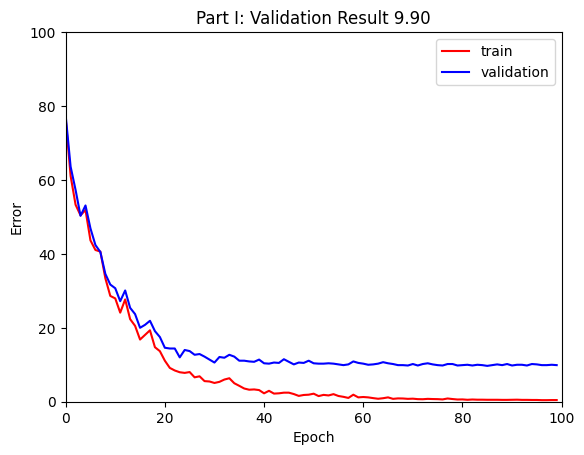

In [ ]:
# loop over the dataset n_epoch times
n_epoch = 100
# store the loss and the % correct at each epoch
losses_train = np.zeros((n_epoch))
errors_train = np.zeros((n_epoch))
losses_val = np.zeros((n_epoch))
errors_val = np.zeros((n_epoch))

for epoch in range(n_epoch):
  # loop over batches
  for i, data in enumerate(data_loader):
    # retrieve inputs and labels for this batch
    x_batch, y_batch = data
    # zero the parameter gradients
    optimizer.zero_grad()
    # forward pass -- calculate model output
    pred = model(x_batch[:,None,:])
    # compute the loss
    loss = loss_function(pred, y_batch)
    # backward pass
    loss.backward()
    # SGD update
    optimizer.step()

  # Run whole dataset to get statistics -- normally wouldn't do this
  pred_train = model(x_train[:,None,:])
  pred_val = model(x_val[:,None,:])
  _, predicted_train_class = torch.max(pred_train.data, 1)
  _, predicted_val_class = torch.max(pred_val.data, 1)
  errors_train[epoch] = 100 - 100 * (predicted_train_class == y_train).float().sum() / len(y_train)
  errors_val[epoch]= 100 - 100 * (predicted_val_class == y_val).float().sum() / len(y_val)
  losses_train[epoch] = loss_function(pred_train, y_train).item()
  losses_val[epoch]= loss_function(pred_val, y_val).item()
  print(f'Epoch {epoch:5d}, train loss {losses_train[epoch]:.6f}, train error {errors_train[epoch]:3.2f},  val loss {losses_val[epoch]:.6f}, percent error {errors_val[epoch]:3.2f}')

  # tell scheduler to consider updating learning rate
  scheduler.step()

# Plot the results
fig, ax = plt.subplots()
ax.plot(errors_train,'r-',label='train')
ax.plot(errors_val,'b-',label='validation')
ax.set_ylim(0,100); ax.set_xlim(0,n_epoch)
ax.set_xlabel('Epoch'); ax.set_ylabel('Error')
ax.set_title('Part I: Validation Result %3.2f'%(errors_val[-1]))
ax.legend()
plt.show()